<h1 align="center">Supervised Machine Learning: Regression -
    Housing Price Prediction</h1>

### Import Required Libraries

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt 
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np


from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV


# 1. Project Objectives

I am passionate about the fact that housing is a human right, and I am interested in exploring data sets about housing. 

The goal of this project is to begin to explore relationships between various population and economic indicators and the average house price by state in the USA. The ultimate focus of the project will be on creating interpretable models to shed some light on which (if any) of the chosen economic data is predictive of the average house price. 

# 2. Data

Here I will download five separate data sets. 

The target data will be gathered from the Zillow Home Value Index (https://www.kaggle.com/datasets/robikscube/zillow-home-value-index?resource=download). It should be noted that this index is based on Zillow sales price estimates, and not actual sales. This data contains columns for each state (plus the District of Columbia) for each month for the past several years. However, I will simplify the target data to be the *average* of the months in 2022 for each state.

The features will all be drawn from data obtained from a USDA portal of county-level data sets available: https://www.ers.usda.gov/data-products/county-level-data-sets/county-level-data-sets-download-data/. However, for this project I will be choosing only the state rows of the data sets rather than all the counties (I leave the county exploration for a later project!) 
The four data sets cover various estimates by state (and county) in four categories:
1. Poverty 
2. Unemployment 
3. Population
4. Education

Although each of these data sets covers slightly different date ranges and some of them only cover up to 2021, I will leave them as is. I would assume that if these indicators have any relationship to house price estimates in 2021, they would also be related to house prices in 2022. My goal is not a year-by-year comparison, but rather seeing if there is any correlation by state.

## Prepare the Data

I will load the data for each set, and do some basic cleaning and transforming.

The main steps for cleaning that I take here are:
1. Unstacking the "Attribute" column (further explained below) so that each different attribute is its own column.
2. Reducing each data set to have one row per state, dropping extra rows (such as those for each county or for the US overall).
3. Renaming the FIPS_Code (unique code for each location) to be consistent so that I can merge the data.
4. Check for null data (which leads to dropping some columns and rows).
5. Merge the five data sets into a single frame.

Expand any of the sections below to show details of how these steps are implemented.

### Poverty

The first file I'm downloading is poverty estimates. I downloaded this from the USDA data portal, but the data is originally from the US census bureau. 

In [2]:
poverty = pd.read_csv('../../../../Downloads/PovertyEstimates.csv')

In [3]:
poverty.head(10)

,FIPS_Code,Stabr,Area_name,Attribute,Value
0,0,US,United States,POVALL_2021,41393176.0
1,0,US,United States,CI90LBALL_2021,41149497.0
2,0,US,United States,CI90UBALL_2021,41636855.0
3,0,US,United States,PCTPOVALL_2021,12.8
4,0,US,United States,CI90LBALLP_2021,12.7
5,0,US,United States,CI90UBALLP_2021,12.9
6,0,US,United States,POV017_2021,12243219.0
7,0,US,United States,CI90LB017_2021,12110180.0
8,0,US,United States,CI90UB017_2021,12376258.0
9,0,US,United States,PCTPOV017_2021,16.9


It looks like instead of one entry per location and multiple columns, this data set has multiple rows for each location, with different "Attributes". I was very confused about this but found documentation on the Excel file that was also available for download, and in this text file as well, which is (I believe) documentation of the same data: https://www2.census.gov/programs-surveys/saipe/technical-documentation/file-layouts/state-county/2022-estimate-layout.txt

In [4]:
poverty['Attribute'].unique()

array(['POVALL_2021', 'CI90LBALL_2021', 'CI90UBALL_2021',
       'PCTPOVALL_2021', 'CI90LBALLP_2021', 'CI90UBALLP_2021',
       'POV017_2021', 'CI90LB017_2021', 'CI90UB017_2021',
       'PCTPOV017_2021', 'CI90LB017P_2021', 'CI90UB017P_2021',
       'POV517_2021', 'CI90LB517_2021', 'CI90UB517_2021',
       'PCTPOV517_2021', 'CI90LB517P_2021', 'CI90UB517P_2021',
       'MEDHHINC_2021', 'CI90LBINC_2021', 'CI90UBINC_2021', 'POV04_2021',
       'CI90LB04_2021', 'CI90UB04_2021', 'PCTPOV04_2021',
       'CI90LB04P_2021', 'CI90UB04P_2021',
       'Rural-urban_Continuum_Code_2003', 'Urban_Influence_Code_2003',
       'Rural-urban_Continuum_Code_2013', 'Urban_Influence_Code_ 2013'],
      dtype=object)

The first few attributes found here are the overall number of individuals in poverty (with additional columns for the 90th percentile lower and upper bounds), the percent of individuals in poverty (again with confidence intervals), number and percent of individuals 0-17 in poverty. 

I need to unstack these attributes to have them in separate columns if I'm going to do anything with this data.

In [5]:
poverty = poverty.pivot(index=["FIPS_Code", "Stabr","Area_name"], columns=["Attribute"], values="Value").reset_index()

In [6]:
poverty.head()

Attribute,FIPS_Code,Stabr,Area_name,CI90LB017P_2021,CI90LB017_2021,CI90LB04P_2021,CI90LB04_2021,CI90LB517P_2021,CI90LB517_2021,CI90LBALLP_2021,...,PCTPOV517_2021,PCTPOVALL_2021,POV017_2021,POV04_2021,POV517_2021,POVALL_2021,Rural-urban_Continuum_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,Urban_Influence_Code_2003
0,0,US,United States,16.7,12110180.0,18.0,3299669.0,15.9,8533254.0,12.7,...,16.1,12.8,12243219.0,3349149.0,8636275.0,41393176.0,NaN,NaN,NaN,NaN
1,1000,AL,Alabama,21.9,241921.0,23.6,66888.0,20.7,169423.0,15.9,...,21.6,16.3,250327.0,71220.0,176596.0,800848.0,NaN,NaN,NaN,NaN
2,1001,AL,Autauga County,11.4,1560.0,NaN,NaN,10.8,1108.0,8.1,...,15.6,10.7,2199.0,NaN,1607.0,6296.0,2.0,2.0,2.0,2.0
3,1003,AL,Baldwin County,13.1,6560.0,NaN,NaN,11.9,4512.0,9.1,...,15.2,10.8,8207.0,NaN,5762.0,25526.0,4.0,3.0,2.0,5.0
4,1005,AL,Barbour County,24.8,1256.0,NaN,NaN,23.0,868.0,17.0,...,33.8,23.0,1776.0,NaN,1276.0,5089.0,6.0,6.0,6.0,6.0


Check for null values:

In [7]:
poverty.isnull().sum()

Attribute
FIPS_Code                             0
Stabr                                 0
Area_name                             0
CI90LB017P_2021                       1
CI90LB017_2021                        1
CI90LB04P_2021                     3143
CI90LB04_2021                      3143
CI90LB517P_2021                       1
CI90LB517_2021                        1
CI90LBALLP_2021                       1
CI90LBALL_2021                        1
CI90LBINC_2021                        1
CI90UB017P_2021                       1
CI90UB017_2021                        1
CI90UB04P_2021                     3143
CI90UB04_2021                      3143
CI90UB517P_2021                       1
CI90UB517_2021                        1
CI90UBALLP_2021                       1
CI90UBALL_2021                        1
CI90UBINC_2021                        1
MEDHHINC_2021                         1
PCTPOV017_2021                        1
PCTPOV04_2021                      3143
PCTPOV517_2021                

It looks like all of the columns with value have at least one null value. I'm wondering if there's one area that doesn't have any data. Let's see what it is by looking at the median household data column:

In [8]:
poverty[poverty['MEDHHINC_2021'].isnull()]

Attribute,FIPS_Code,Stabr,Area_name,CI90LB017P_2021,CI90LB017_2021,CI90LB04P_2021,CI90LB04_2021,CI90LB517P_2021,CI90LB517_2021,CI90LBALLP_2021,...,PCTPOV517_2021,PCTPOVALL_2021,POV017_2021,POV04_2021,POV517_2021,POVALL_2021,Rural-urban_Continuum_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,Urban_Influence_Code_2003
562,15005,HI,Kalawao County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9.0,3.0,2.0,8.0


Okay, looks like we don't have data for Kalawao County, Hawaii. I think I'll be okay with dropping that one county if I do a county-level study, but for now I'm going to do it by state anyway.

FIPS Codes here are given as the 2-digit state code plus a 3-digit county code. If I want to just use the state (+DC) rows and not the county ones, I can find the codes that end in 000 (minus the US (0)). 

In [9]:
statepoverty = poverty[poverty['FIPS_Code']%1000==0].copy()

In [10]:
statepoverty.head()

Attribute,FIPS_Code,Stabr,Area_name,CI90LB017P_2021,CI90LB017_2021,CI90LB04P_2021,CI90LB04_2021,CI90LB517P_2021,CI90LB517_2021,CI90LBALLP_2021,...,PCTPOV517_2021,PCTPOVALL_2021,POV017_2021,POV04_2021,POV517_2021,POVALL_2021,Rural-urban_Continuum_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,Urban_Influence_Code_2003
0,0,US,United States,16.7,12110180.0,18.0,3299669.0,15.9,8533254.0,12.7,...,16.1,12.8,12243219.0,3349149.0,8636275.0,41393176.0,NaN,NaN,NaN,NaN
1,1000,AL,Alabama,21.9,241921.0,23.6,66888.0,20.7,169423.0,15.9,...,21.6,16.3,250327.0,71220.0,176596.0,800848.0,NaN,NaN,NaN,NaN
69,2000,AK,Alaska,12.7,22273.0,12.3,5796.0,11.8,15103.0,10.3,...,12.7,10.8,23760.0,6633.0,16316.0,77736.0,NaN,NaN,NaN,NaN
100,4000,AZ,Arizona,17.2,271479.0,18.4,71494.0,16.0,189061.0,12.6,...,16.7,12.9,281696.0,76649.0,197841.0,919680.0,NaN,NaN,NaN,NaN
116,5000,AR,Arkansas,21.0,144623.0,23.9,42186.0,19.1,97845.0,15.6,...,20.1,16.0,150353.0,45096.0,102718.0,471195.0,NaN,NaN,NaN,NaN


The rural-urban continuum and urban influence codes will also be useful for a county level study, but I'll drop these columns since they're not available for each state.

In [11]:
statepoverty.drop(index=0,inplace=True)

In [12]:
statepoverty.drop(columns=['Rural-urban_Continuum_Code_2003','Rural-urban_Continuum_Code_2013',
                           'Urban_Influence_Code_ 2013','Urban_Influence_Code_2003'],inplace=True)

In [13]:
statepoverty.isnull().sum()

Attribute
FIPS_Code          0
Stabr              0
Area_name          0
CI90LB017P_2021    0
CI90LB017_2021     0
CI90LB04P_2021     0
CI90LB04_2021      0
CI90LB517P_2021    0
CI90LB517_2021     0
CI90LBALLP_2021    0
CI90LBALL_2021     0
CI90LBINC_2021     0
CI90UB017P_2021    0
CI90UB017_2021     0
CI90UB04P_2021     0
CI90UB04_2021      0
CI90UB517P_2021    0
CI90UB517_2021     0
CI90UBALLP_2021    0
CI90UBALL_2021     0
CI90UBINC_2021     0
MEDHHINC_2021      0
PCTPOV017_2021     0
PCTPOV04_2021      0
PCTPOV517_2021     0
PCTPOVALL_2021     0
POV017_2021        0
POV04_2021         0
POV517_2021        0
POVALL_2021        0
dtype: int64

In [14]:
statepoverty.head()

Attribute,FIPS_Code,Stabr,Area_name,CI90LB017P_2021,CI90LB017_2021,CI90LB04P_2021,CI90LB04_2021,CI90LB517P_2021,CI90LB517_2021,CI90LBALLP_2021,...,CI90UBINC_2021,MEDHHINC_2021,PCTPOV017_2021,PCTPOV04_2021,PCTPOV517_2021,PCTPOVALL_2021,POV017_2021,POV04_2021,POV517_2021,POVALL_2021
1,1000,AL,Alabama,21.9,241921.0,23.6,66888.0,20.7,169423.0,15.9,...,54762.0,53990.0,22.7,25.1,21.6,16.3,250327.0,71220.0,176596.0,800848.0
69,2000,AK,Alaska,12.7,22273.0,12.3,5796.0,11.8,15103.0,10.3,...,80418.0,78437.0,13.5,14.1,12.7,10.8,23760.0,6633.0,16316.0,77736.0
100,4000,AZ,Arizona,17.2,271479.0,18.4,71494.0,16.0,189061.0,12.6,...,69647.0,68967.0,17.8,19.7,16.7,12.9,281696.0,76649.0,197841.0,919680.0
116,5000,AR,Arkansas,21.0,144623.0,23.9,42186.0,19.1,97845.0,15.6,...,53559.0,52577.0,21.8,25.5,20.1,16.0,150353.0,45096.0,102718.0,471195.0
192,6000,CA,California,15.5,1333900.0,15.2,326796.0,15.0,967041.0,12.2,...,85370.0,84831.0,15.8,15.8,15.4,12.3,1362903.0,339169.0,993484.0,4742405.0


In [15]:
statepoverty.Stabr.unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

### Unemployment

In [16]:
unempl = pd.read_csv('../../../../Downloads/Unemployment.csv')

In [17]:
unempl.head()

,FIPS_Code,State,Area_Name,Attribute,Value
0,0,US,United States,Civilian_labor_force_2000,142601576.0
1,0,US,United States,Employed_2000,136904853.0
2,0,US,United States,Unemployed_2000,5696723.0
3,0,US,United States,Unemployment_rate_2000,4.0
4,0,US,United States,Civilian_labor_force_2001,143786537.0


In [18]:
unempl = unempl.pivot(index=["FIPS_Code", "State","Area_Name"], columns=["Attribute"], values="Value").reset_index()

In [19]:
unempl.head()

Attribute,FIPS_Code,State,Area_Name,Civilian_labor_force_2000,Civilian_labor_force_2001,Civilian_labor_force_2002,Civilian_labor_force_2003,Civilian_labor_force_2004,Civilian_labor_force_2005,Civilian_labor_force_2006,...,Unemployment_rate_2014,Unemployment_rate_2015,Unemployment_rate_2016,Unemployment_rate_2017,Unemployment_rate_2018,Unemployment_rate_2019,Unemployment_rate_2020,Unemployment_rate_2021,Unemployment_rate_2022,Urban_Influence_Code_2013
0,0,US,United States,142601576.0,143786537.0,144839298.0,145660094.0,146724795.0,148597241.0,150707773.0,...,6.2,5.3,4.9,4.4,3.9,3.7,8.1,5.4,3.7,NaN
1,1000,AL,Alabama,2147173.0,2128027.0,2112621.0,2128668.0,2138306.0,2140356.0,2170007.0,...,6.7,6.1,5.9,4.5,3.9,3.2,6.4,3.4,2.6,NaN
2,1001,AL,"Autauga County, AL",21861.0,22081.0,22161.0,22695.0,23241.0,23887.0,24425.0,...,5.8,5.2,5.1,4.0,3.6,2.9,5.3,2.8,2.3,2.0
3,1003,AL,"Baldwin County, AL",69979.0,69569.0,69379.0,72598.0,74843.0,76608.0,79806.0,...,6.1,5.6,5.4,4.2,3.6,2.9,6.1,2.9,2.4,2.0
4,1005,AL,"Barbour County, AL",11449.0,11324.0,11006.0,11019.0,10639.0,10730.0,10713.0,...,10.5,8.9,8.4,6.0,5.1,4.0,7.7,5.5,4.1,6.0


In [20]:
unempl_state=unempl[unempl['FIPS_Code']%1000==0].copy()

In [21]:
unempl_state.drop(index=0,inplace=True)

In [22]:
unempl_state.drop(columns=['Urban_Influence_Code_2013','Metro_2013','Rural_Urban_Continuum_Code_2013'],inplace=True)

In [23]:
unempl_state.isnull().sum()

Attribute
FIPS_Code                    0
State                        0
Area_Name                    0
Civilian_labor_force_2000    0
Civilian_labor_force_2001    0
                            ..
Unemployment_rate_2018       0
Unemployment_rate_2019       0
Unemployment_rate_2020       1
Unemployment_rate_2021       0
Unemployment_rate_2022       0
Length: 97, dtype: int64

In [24]:
unempl_state[unempl_state['Unemployment_rate_2020'].isnull()]

Attribute,FIPS_Code,State,Area_Name,Civilian_labor_force_2000,Civilian_labor_force_2001,Civilian_labor_force_2002,Civilian_labor_force_2003,Civilian_labor_force_2004,Civilian_labor_force_2005,Civilian_labor_force_2006,...,Unemployment_rate_2013,Unemployment_rate_2014,Unemployment_rate_2015,Unemployment_rate_2016,Unemployment_rate_2017,Unemployment_rate_2018,Unemployment_rate_2019,Unemployment_rate_2020,Unemployment_rate_2021,Unemployment_rate_2022
3198,72000,PR,Puerto Rico,1291993.0,1273405.0,1321370.0,1345782.0,1347047.0,1378062.0,1419874.0,...,14.3,13.9,12.0,11.8,10.8,9.2,8.3,NaN,7.9,6.0


Since my other data set doesn't include Puerto Rico anyway, I'll drop it from this data set as well.

In [25]:
unempl_state.drop(index=3198,inplace=True)

In [26]:
unempl_state.isnull().sum().sum()

0

In [27]:
unempl_state.State.unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

In [28]:
unempl_state.drop(columns=['State','Area_Name'],inplace=True)

### Population

In [29]:
pop = pd.read_csv('../../../../Downloads/PopulationEstimates.csv',encoding='latin-1')

In [30]:
pop.head()

,FIPStxt,State,Area_Name,Attribute,Value
0,0,US,United States,CENSUS_2020_POP,331449281.0
1,0,US,United States,ESTIMATES_BASE_2020,331449520.0
2,0,US,United States,POP_ESTIMATE_2020,331511512.0
3,0,US,United States,POP_ESTIMATE_2021,332031554.0
4,0,US,United States,POP_ESTIMATE_2022,333287557.0


In [31]:
pop = pop.pivot(index=["FIPStxt", "State","Area_Name"], columns=["Attribute"], values="Value").reset_index()

In [32]:
pop.head()

Attribute,FIPStxt,State,Area_Name,BIRTHS_2020,BIRTHS_2021,BIRTHS_2022,CENSUS_2020_POP,DEATHS_2020,DEATHS_2021,DEATHS_2022,...,R_INTERNATIONAL_MIG_2021,R_INTERNATIONAL_MIG_2022,R_NATURAL_CHG_2021,R_NATURAL_CHG_2022,R_NET_MIG_2021,R_NET_MIG_2022,Rural_Urban_Continuum_Code_2003,Rural_Urban_Continuum_Code_2013,Urban_Influence_2003,Urban_Influence_2013
0,0,US,United States,894123.0,3582436.0,3688179.0,331449281.0,852024.0,3438423.0,3443099.0,...,1.1,3.0,0.4,0.7,1.1,3.0,NaN,NaN,NaN,NaN
1,1000,AL,Alabama,13867.0,57112.0,58280.0,5024279.0,15165.0,69056.0,66870.0,...,0.4,0.9,-2.4,-1.7,5.9,6.6,NaN,NaN,NaN,NaN
2,1001,AL,Autauga County,162.0,694.0,709.0,58805.0,177.0,682.0,673.0,...,0.3,0.5,0.2,0.6,4.3,9.0,2.0,2.0,2.0,2.0
3,1003,AL,Baldwin County,560.0,2367.0,2411.0,231767.0,593.0,3044.0,2909.0,...,0.4,1.3,-2.9,-2.1,29.9,30.0,4.0,3.0,5.0,2.0
4,1005,AL,Barbour County,60.0,276.0,277.0,25223.0,93.0,383.0,372.0,...,0.0,0.2,-4.3,-3.9,-12.4,10.0,6.0,6.0,6.0,6.0


In [33]:
statepop = pop[pop['FIPStxt']%1000==0].copy()

In [34]:
statepop.drop(columns=['Rural_Urban_Continuum_Code_2003',
                       'Rural_Urban_Continuum_Code_2013',
                       'Urban_Influence_2003',
                       'Urban_Influence_2013'], inplace=True)

In [35]:
statepop.drop(index=0,inplace=True)

In [36]:
statepop.isnull().sum()

Attribute
FIPStxt                      0
State                        0
Area_Name                    0
BIRTHS_2020                  1
BIRTHS_2021                  1
BIRTHS_2022                  1
CENSUS_2020_POP              0
DEATHS_2020                  1
DEATHS_2021                  1
DEATHS_2022                  1
DOMESTIC_MIG_2020            1
DOMESTIC_MIG_2021            1
DOMESTIC_MIG_2022            1
ESTIMATES_BASE_2020          0
Economic_typology_2015      52
GQ_ESTIMATES_2020            1
GQ_ESTIMATES_2021            1
GQ_ESTIMATES_2022            1
GQ_ESTIMATES_BASE_2020       1
INTERNATIONAL_MIG_2020       1
INTERNATIONAL_MIG_2021       1
INTERNATIONAL_MIG_2022       1
NATURAL_CHG_2020             1
NATURAL_CHG_2021             1
NATURAL_CHG_2022             1
NET_MIG_2020                 1
NET_MIG_2021                 1
NET_MIG_2022                 1
N_POP_CHG_2020               1
N_POP_CHG_2021               1
N_POP_CHG_2022               1
POP_ESTIMATE_2020            

In [37]:
statepop[statepop['BIRTHS_2020'].isnull()]

Attribute,FIPStxt,State,Area_Name,BIRTHS_2020,BIRTHS_2021,BIRTHS_2022,CENSUS_2020_POP,DEATHS_2020,DEATHS_2021,DEATHS_2022,...,R_DEATH_2021,R_DEATH_2022,R_DOMESTIC_MIG_2021,R_DOMESTIC_MIG_2022,R_INTERNATIONAL_MIG_2021,R_INTERNATIONAL_MIG_2022,R_NATURAL_CHG_2021,R_NATURAL_CHG_2022,R_NET_MIG_2021,R_NET_MIG_2022
3204,72000,PR,Puerto Rico,NaN,NaN,NaN,3285874.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
statepop.drop(columns='Economic_typology_2015',inplace=True)
statepop.drop(index=3204,inplace=True)

In [39]:
statepop.isnull().sum().sum()

0

In [40]:
statepop.State.unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

In [41]:
statepop.rename(columns={'FIPStxt':'FIPS_Code'},inplace=True)

In [42]:
statepop.drop(columns=['State','Area_Name'],inplace=True)

### Education

In [43]:
edu = pd.read_csv('../../../../Downloads/Education.csv',encoding='latin-1')

In [44]:
edu.head()

,Federal Information Processing Standard (FIPS) Code,State,Area name,Attribute,Value
0,0,US,United States,"Less than a high school diploma, 1970",52373312.0
1,0,US,United States,"High school diploma only, 1970",34158051.0
2,0,US,United States,"Some college (1-3 years), 1970",11650730.0
3,0,US,United States,"Four years of college or higher, 1970",11717266.0
4,0,US,United States,Percent of adults with less than a high school...,47.7


In [45]:
edu = edu.pivot(index=["Federal Information Processing Standard (FIPS) Code", "State","Area name"], columns=["Attribute"], values="Value").reset_index()

In [46]:
edustate=edu[edu['Federal Information Processing Standard (FIPS) Code']%1000==0].copy()

In [47]:
edustate.drop(columns=['2003 Rural-urban Continuum Code',
       '2003 Urban Influence Code', '2013 Rural-urban Continuum Code',
       '2013 Urban Influence Code'],inplace=True)

In [48]:
edustate.head()

Attribute,Federal Information Processing Standard (FIPS) Code,State,Area name,"Bachelor's degree or higher, 1990","Bachelor's degree or higher, 2000","Bachelor's degree or higher, 2008-12","Bachelor's degree or higher, 2017-21","Four years of college or higher, 1970","Four years of college or higher, 1980","High school diploma only, 1970",...,"Percent of adults with less than a high school diploma, 1990","Percent of adults with less than a high school diploma, 2000","Percent of adults with less than a high school diploma, 2008-12","Percent of adults with less than a high school diploma, 2017-21","Some college (1-3 years), 1970","Some college (1-3 years), 1980","Some college or associate's degree, 1990","Some college or associate's degree, 2000","Some college or associate's degree, 2008-12","Some college or associate's degree, 2017-21"
0,0,US,United States,32310253.0,44462605.0,58205022.0,75808834.0,11717266.0,21558480.0,34158051.0,...,24.8,19.6,14.280311,11.125960,11650730.0,20794975.0,39571702.0,49864428.0,59244324.0,64656741.0
1,1000,AL,Alabama,399228.0,549608.0,705001.0,910425.0,141936.0,270063.0,468269.0,...,33.1,24.7,17.402281,12.597300,136287.0,278205.0,553512.0,746495.0,918987.0,1032122.0
69,2000,AK,Alaska,74497.0,93807.0,122968.0,148191.0,19082.0,44554.0,50820.0,...,13.4,11.7,8.413046,6.744470,20052.0,47722.0,112763.0,135655.0,165651.0,165649.0
108,4000,AZ,Arizona,466873.0,766212.0,1105103.0,1495416.0,115020.0,271460.0,289781.0,...,21.3,19.0,14.557652,11.695726,127063.0,321361.0,741784.0,1078521.0,1428213.0,1610633.0
124,5000,AR,Arkansas,199304.0,288428.0,380334.0,491269.0,70378.0,144677.0,271150.0,...,33.7,24.7,16.693727,12.305063,80835.0,153375.0,303795.0,424907.0,545270.0,592568.0


In [49]:
edustate.drop(index=0,inplace=True)

In [50]:
edustate[edustate['State']=='PR']

Attribute,Federal Information Processing Standard (FIPS) Code,State,Area name,"Bachelor's degree or higher, 1990","Bachelor's degree or higher, 2000","Bachelor's degree or higher, 2008-12","Bachelor's degree or higher, 2017-21","Four years of college or higher, 1970","Four years of college or higher, 1980","High school diploma only, 1970",...,"Percent of adults with less than a high school diploma, 1990","Percent of adults with less than a high school diploma, 2000","Percent of adults with less than a high school diploma, 2008-12","Percent of adults with less than a high school diploma, 2017-21","Some college (1-3 years), 1970","Some college (1-3 years), 1980","Some college or associate's degree, 1990","Some college or associate's degree, 2000","Some college or associate's degree, 2008-12","Some college or associate's degree, 2017-21"
3206,72000,PR,Puerto Rico,278482.0,418253.0,548830.0,658110.0,NaN,147920.0,NaN,...,50.3,40.0,30.307,21.639673,NaN,142981.0,281248.0,443813.0,524750.0,549350.0


In [51]:
edustate.drop(index=3206,inplace=True)

In [52]:
edustate.isnull().sum().sum()

0

In [53]:
edustate.rename(columns={'Federal Information Processing Standard (FIPS) Code':'FIPS_Code'},inplace=True)

In [54]:
edustate.head()

Attribute,FIPS_Code,State,Area name,"Bachelor's degree or higher, 1990","Bachelor's degree or higher, 2000","Bachelor's degree or higher, 2008-12","Bachelor's degree or higher, 2017-21","Four years of college or higher, 1970","Four years of college or higher, 1980","High school diploma only, 1970",...,"Percent of adults with less than a high school diploma, 1990","Percent of adults with less than a high school diploma, 2000","Percent of adults with less than a high school diploma, 2008-12","Percent of adults with less than a high school diploma, 2017-21","Some college (1-3 years), 1970","Some college (1-3 years), 1980","Some college or associate's degree, 1990","Some college or associate's degree, 2000","Some college or associate's degree, 2008-12","Some college or associate's degree, 2017-21"
1,1000,AL,Alabama,399228.0,549608.0,705001.0,910425.0,141936.0,270063.0,468269.0,...,33.1,24.7,17.402281,12.597300,136287.0,278205.0,553512.0,746495.0,918987.0,1032122.0
69,2000,AK,Alaska,74497.0,93807.0,122968.0,148191.0,19082.0,44554.0,50820.0,...,13.4,11.7,8.413046,6.744470,20052.0,47722.0,112763.0,135655.0,165651.0,165649.0
108,4000,AZ,Arizona,466873.0,766212.0,1105103.0,1495416.0,115020.0,271460.0,289781.0,...,21.3,19.0,14.557652,11.695726,127063.0,321361.0,741784.0,1078521.0,1428213.0,1610633.0
124,5000,AR,Arkansas,199304.0,288428.0,380334.0,491269.0,70378.0,144677.0,271150.0,...,33.7,24.7,16.693727,12.305063,80835.0,153375.0,303795.0,424907.0,545270.0,592568.0
200,6000,CA,California,4366674.0,5669966.0,7344555.0,9451438.0,1462266.0,2752865.0,3566578.0,...,23.8,23.2,18.980109,15.807829,1784772.0,3150653.0,5710400.0,6397739.0,7206710.0,7632443.0


In [55]:
edustate.drop(columns=['State','Area name'],inplace=True)

### Zillow

Finally, our target data set will be from Zillow. Since this is from a different source, it is in a different format and my cleaning steps will be a little different.

In [56]:
zillow = pd.read_csv('../../../../Downloads/archive/ZHVI.csv')

In [57]:
zillow.head()

,Unnamed: 0,Virginia,California,Florida,New York,Alaska,Texas,North Carolina,Michigan,Rhode Island,...,West Virginia,Kansas,South Dakota,Maine,Mississippi,Pennsylvania,North Dakota,Montana,Delaware,Louisiana
0,2000-01-01,121541.910387,187481.071355,107011.618372,152778.018340,131599.268788,109950.810484,126877.864263,115152.905254,130073.001963,...,72748.058698,87225.894904,106386.162134,106412.550834,84883.096591,97630.339458,NaN,NaN,145351.978372,102565.423063
1,2000-02-01,121856.416139,188111.251195,107243.415499,153322.058161,131748.737755,110010.560594,127070.892533,115216.328725,130664.562846,...,72744.944690,87243.017512,106160.126686,106766.587342,84836.544030,97839.163361,NaN,NaN,145578.112692,102763.262499
2,2000-03-01,122189.866064,188962.148293,107524.399821,153845.784223,131898.128551,110039.540334,127269.707774,115448.526420,131285.799082,...,72768.459104,87343.894259,105843.806802,107082.696734,84834.518808,98035.401735,NaN,NaN,145859.670275,102917.000369
3,2000-04-01,122819.975523,190809.192179,108095.568678,154972.176609,132073.329037,110183.369352,127700.973151,115911.063315,132513.260512,...,72827.975481,87494.697974,105417.441523,107779.103924,84895.715033,98435.305723,NaN,NaN,146503.586089,103263.593757
4,2000-05-01,123428.277186,192956.102457,108711.512739,156137.590080,132337.079641,110276.515279,128181.426744,116593.170243,133736.370550,...,72944.088937,87722.021073,105240.061108,108435.123109,85193.507040,98846.107250,NaN,NaN,147238.000735,103630.805930


The first column is the date, although the name is "Unnamed: 0" which isn't very clear. After that there is one column per state. I will replace the unnamed column with just the year, then aggregate by year to get the average house price per year, then select just 2022.

In [58]:
zillow['Year']=pd.to_datetime(zillow['Unnamed: 0']).dt.year

In [59]:
zillow.drop(columns = ['Unnamed: 0'],inplace=True)

In [60]:
house_yearly = zillow.groupby('Year').mean().reset_index()

Since I want to combine this with my other data sets, I'm going to need to make sure I have consistent names of states to combine on.

In [61]:
house_yearly.columns

Index(['Year', 'Virginia', 'California', 'Florida', 'New York', 'Alaska',
       'Texas', 'North Carolina', 'Michigan', 'Rhode Island', 'New Hampshire',
       'New Jersey', 'Illinois', 'the District of Columbia', 'Georgia',
       'Alabama', 'Arizona', 'Washington', 'Hawaii', 'Massachusetts',
       'Arkansas', 'Colorado', 'Nevada', 'Tennessee', 'South Carolina',
       'Maryland', 'Minnesota', 'Wisconsin', 'Nebraska', 'Utah', 'Oregon',
       'Iowa', 'Vermont', 'Connecticut', 'Oklahoma', 'Kentucky', 'Missouri',
       'Idaho', 'Ohio', 'Indiana', 'Wyoming', 'New Mexico', 'West Virginia',
       'Kansas', 'South Dakota', 'Maine', 'Mississippi', 'Pennsylvania',
       'North Dakota', 'Montana', 'Delaware', 'Louisiana'],
      dtype='object')

In [62]:
set(house_yearly.columns) ^ set(statepoverty['Area_name'])

{'District of Columbia', 'Year', 'the District of Columbia'}

So I need to rename DC to be consistent, and after I aggregate by Year I will drop the Year column.

In [63]:
house_yearly.rename(columns={'the District of Columbia': 'District of Columbia'}, inplace=True)

In [64]:
housing2022 = house_yearly[house_yearly['Year']==2022].drop(columns=['Year']).T.reset_index()

In [65]:
housing2022.head()

,index,22
0,Virginia,350331.406211
1,California,737692.353437
2,Florida,372291.537358
3,New York,434997.014268
4,Alaska,343913.343560


Finally I'll rename these columns.

In [66]:
housing2022.rename(columns={'index':'Area_name', 22:'AverageHousePrice'},inplace=True)

### Merge Data Sets

In [67]:
df_merged = statepoverty.merge(statepop,on='FIPS_Code')
df_merged=df_merged.merge(unempl_state,on='FIPS_Code')
df_merged=df_merged.merge(edustate,on='FIPS_Code')

In [68]:
df_merged.head()

Attribute,FIPS_Code,Stabr,Area_name,CI90LB017P_2021,CI90LB017_2021,CI90LB04P_2021,CI90LB04_2021,CI90LB517P_2021,CI90LB517_2021,CI90LBALLP_2021,...,"Percent of adults with less than a high school diploma, 1990","Percent of adults with less than a high school diploma, 2000","Percent of adults with less than a high school diploma, 2008-12","Percent of adults with less than a high school diploma, 2017-21","Some college (1-3 years), 1970","Some college (1-3 years), 1980","Some college or associate's degree, 1990","Some college or associate's degree, 2000","Some college or associate's degree, 2008-12","Some college or associate's degree, 2017-21"
0,1000,AL,Alabama,21.9,241921.0,23.6,66888.0,20.7,169423.0,15.9,...,33.1,24.7,17.402281,12.597300,136287.0,278205.0,553512.0,746495.0,918987.0,1032122.0
1,2000,AK,Alaska,12.7,22273.0,12.3,5796.0,11.8,15103.0,10.3,...,13.4,11.7,8.413046,6.744470,20052.0,47722.0,112763.0,135655.0,165651.0,165649.0
2,4000,AZ,Arizona,17.2,271479.0,18.4,71494.0,16.0,189061.0,12.6,...,21.3,19.0,14.557652,11.695726,127063.0,321361.0,741784.0,1078521.0,1428213.0,1610633.0
3,5000,AR,Arkansas,21.0,144623.0,23.9,42186.0,19.1,97845.0,15.6,...,33.7,24.7,16.693727,12.305063,80835.0,153375.0,303795.0,424907.0,545270.0,592568.0
4,6000,CA,California,15.5,1333900.0,15.2,326796.0,15.0,967041.0,12.2,...,23.8,23.2,18.980109,15.807829,1784772.0,3150653.0,5710400.0,6397739.0,7206710.0,7632443.0


In [69]:
df_merged=df_merged.merge(housing2022,on='Area_name')

In [70]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Columns: 218 entries, FIPS_Code to AverageHousePrice
dtypes: float64(215), int64(1), object(2)
memory usage: 87.0+ KB


## Exploratory Data Analysis

Here I'll do some basic data analysis to compare these columns

In [71]:
X = df_merged.drop(columns=['FIPS_Code','Area_name','Stabr'])#,'AverageHousePrice'])

In [72]:
corr_matrix = X.corr()

<Axes: >

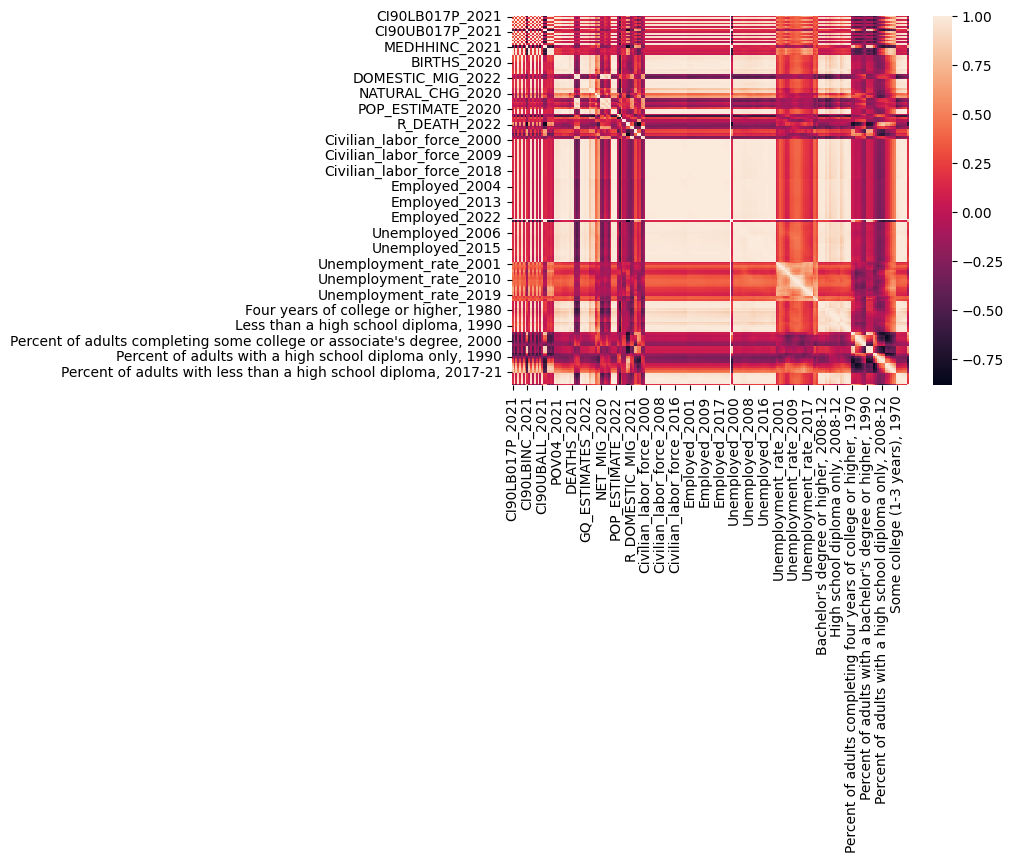

In [73]:
sns.heatmap(corr_matrix)

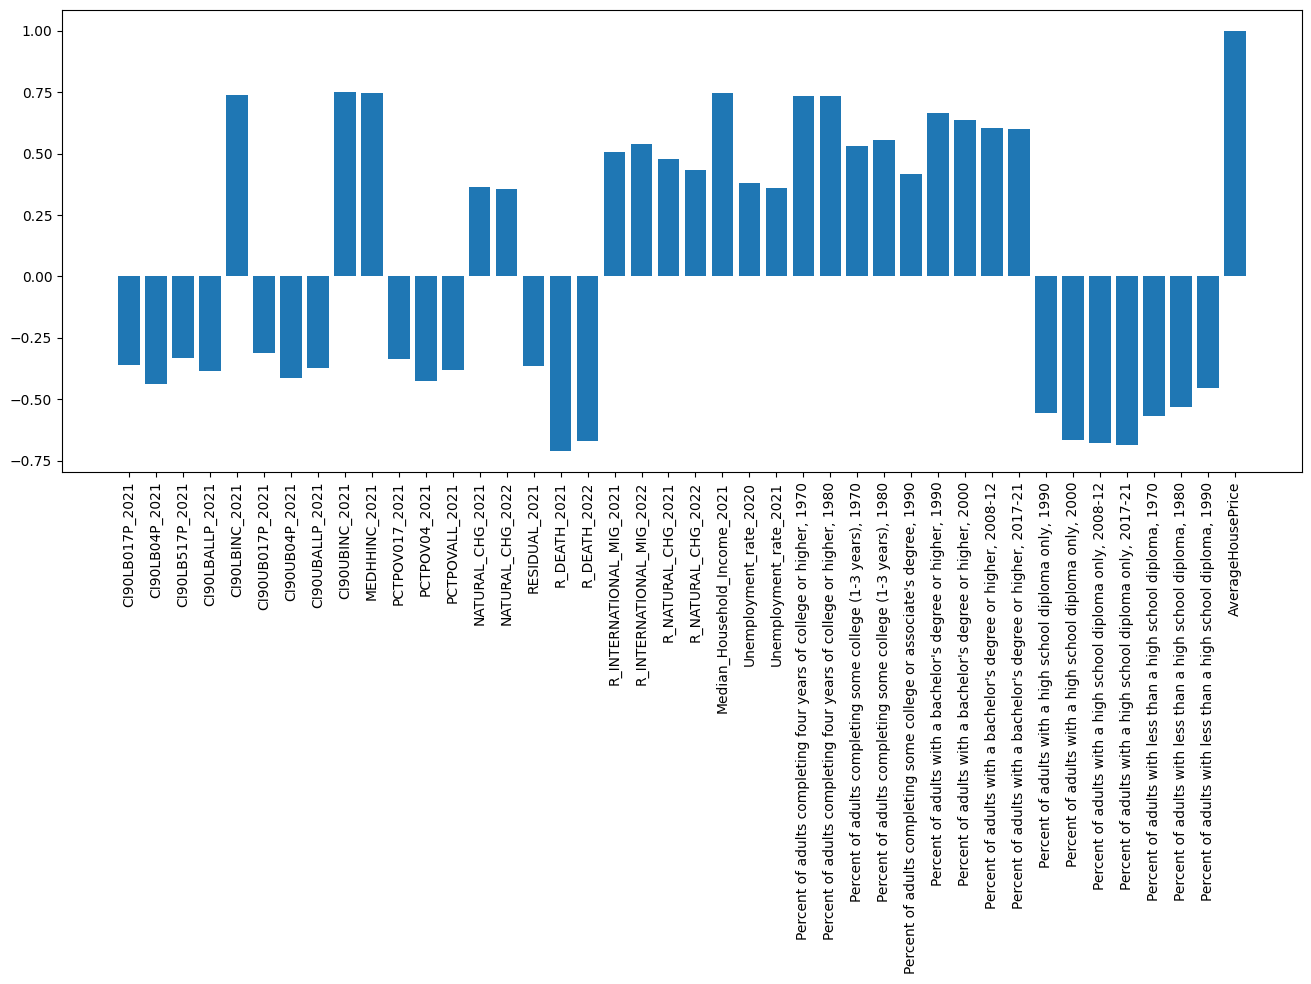

In [74]:
plt.figure(figsize=[16,6])
plt.bar(height=corr_matrix[abs(corr_matrix['AverageHousePrice'])>0.3]['AverageHousePrice'],
        x=corr_matrix[abs(corr_matrix['AverageHousePrice'])>0.3]['AverageHousePrice'].keys())
ticks=plt.xticks(rotation=90)

Just from the simple correlation matrix, I can see a few patterns on what is correlated (or anti-correlated). The highest positive correlation with home price by state is average household income (which is related to several columns here, including upper and lower confidence interval columns). Shortly behind that is a group of columns relating to the percent of adults with college degrees or higher. The strongest negative correlations are death rates and the percent of adults with only a high school degree (or less). 

# 3. Linear Regression Models
Now I'm going to try a few methods of linear regression, predicting the Zillow average house price from the other data. The three methods that I will use are 1) Linear regression with all the variables, 2) Regularization using Ridge and RidgeCV, and 3) Regularization using Lasso and LassoCV.

In [75]:
# First create target and feature variables, and then training and test sets
X = X.drop(columns=['AverageHousePrice'])

In [76]:
y = df_merged['AverageHousePrice']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Linear regression
I'll start with just doing linear regression, no feature selection or scaling

In [78]:
lm = LinearRegression()
lm.fit(X_train,y_train)
lm.score(X_train,y_train)

1.0

So this is just perfect on the training set!

In [79]:
y_pred=lm.predict(X_test)

In [80]:
r2_score(y_test,y_pred)

-111.4701495661204

And awful on the test set!! Looks like we're definitely overfitting and need to apply some regularization. This makes sense since we have a lot of columns that are correlated with each other, and we shouldn't need them all.

## Ridge regression

Since I will be applying regularization, first I will need to standardize the data!

In [81]:
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

I will apply Ridge regression over a series of alphas and plot how the sum of the coefficients and the R2 score change with the different alphas:

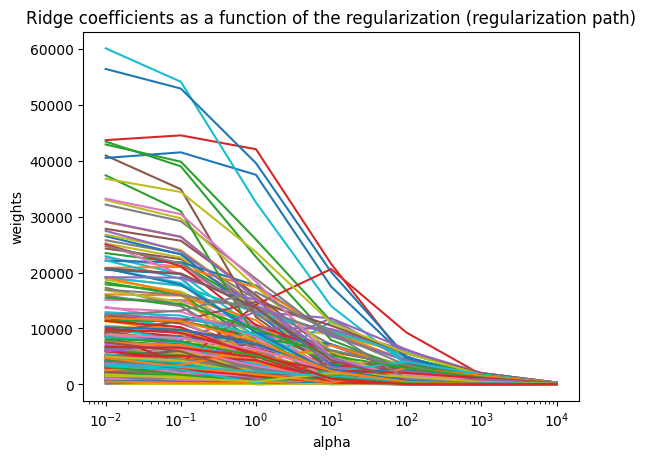

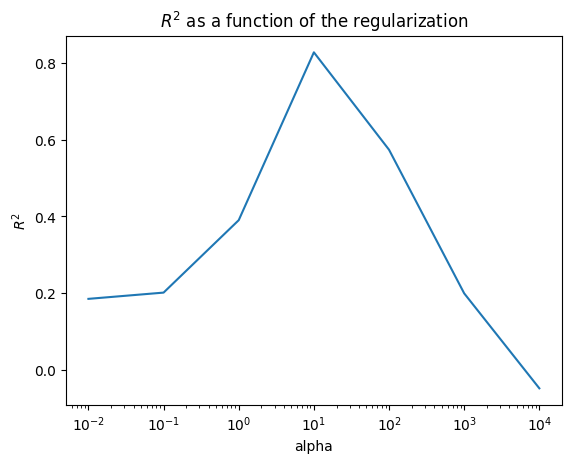

In [82]:
alphas = [0.01,0.1,1,10,1E2,1E3,1E4]
R_2=[]
coefs = []
for alpha in alphas:
    lr=Ridge(alpha=alpha)
    
    lr.fit(X_train_scaled, y_train)
    coefs.append(abs(lr.coef_))
    R_2.append(lr.score(X_test_scaled,y_test))


ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization (regularization path)")
plt.show()


ax = plt.gca()
ax.plot(alphas, R_2)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("$R^2$")
plt.title("$R^2$ as a function of the regularization")
plt.show()

I can see my coefficient weights drop with higher regularization, which makes sense. The R2 score increases up to alpha of 10, as the model gets less overfit. Then the R2 score goes down again at higher and higher alpha, which would indicate underfitting. 

I will next do a similar test but using LassoCV to choose the model for me.

In [83]:
alphas = [0.01,0.1,1.0,10,1E2,1E3,1E4]

ridgeCV = RidgeCV(alphas=alphas, 
                  cv=4).fit(X_train_scaled, y_train)

In [84]:
ridgeCV.alpha_

100.0

In [85]:
ridgeCV.score(X_train_scaled,y_train)

0.7519989407135754

In [86]:
ridgeCV.score(X_test_scaled,y_test)

0.5733646159204157

It's interesting that ridgeCV chose alpha of 100, which wasn't as good as alpha of 10 on my previous test. I assume that's because before I was only testing on one train/test split, and this incorporates cross-validation so there are multiple tests. 

Still, the score on test data of almost 0.6 isn't too bad. It means this would not be a great predictive model, but still might offer some insights for interpretation. To do that, I'll plot some of the largest coefficients:

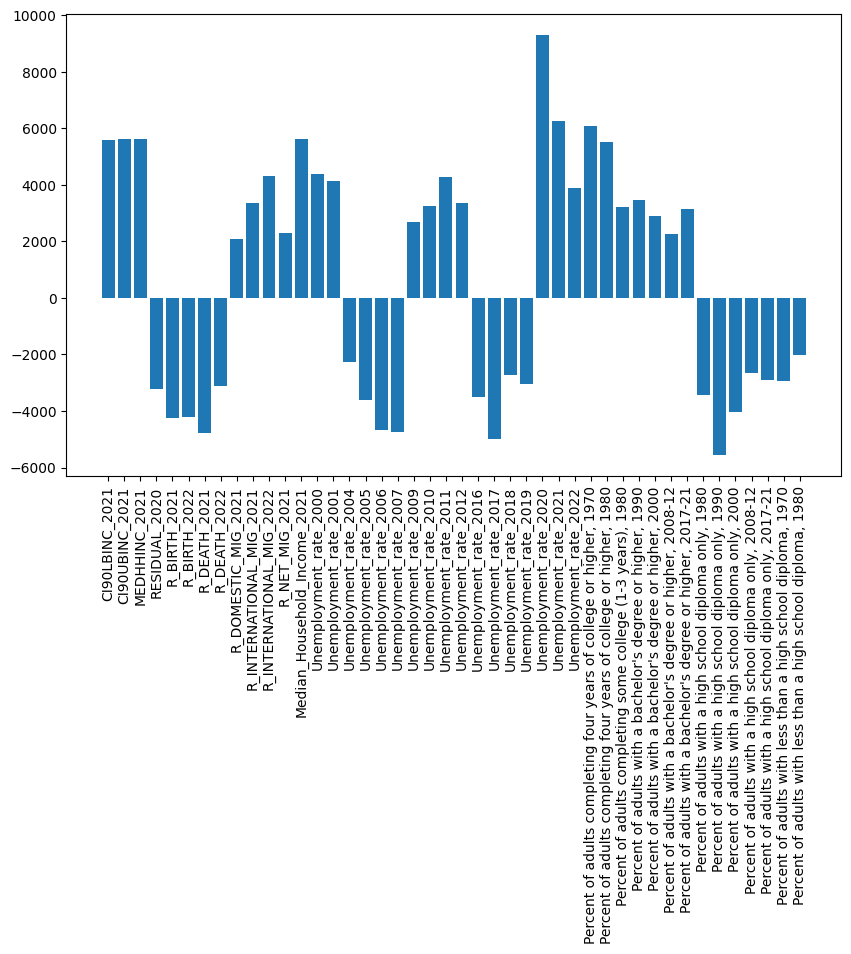

In [87]:
plt.figure(figsize=[10,6])
plt.bar(x=X_train.columns[abs(ridgeCV.coef_)>2000],height=ridgeCV.coef_[abs(ridgeCV.coef_)>2000])
xticks=plt.xticks(rotation=90)

It's interesting to me that the highest coefficient is the 2020 unemployment rate! And lots of unemployment rates are chosen, though some years have positive coefficients (2000-2001,2009-2012,2020-2022) while other years are negatively correlated. I really don't know what to do with that information, and might want to follow up on that later. (Maybe the sign switch is related to recession effects?)

Besides that I se some of the same effects as when I just plotted the correlation matrix - e.g. positive correlation with higher education rates and income.

## Lasso Regression

I will repeat the same process but with Lasso and LassoCV

/Users/marissawalker/mambaforge/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.178e+07, tolerance: 6.424e+07
  model = cd_fast.enet_coordinate_descent(
/Users/marissawalker/mambaforge/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.308e+08, tolerance: 6.424e+07
  model = cd_fast.enet_coordinate_descent(
/Users/marissawalker/mambaforge/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

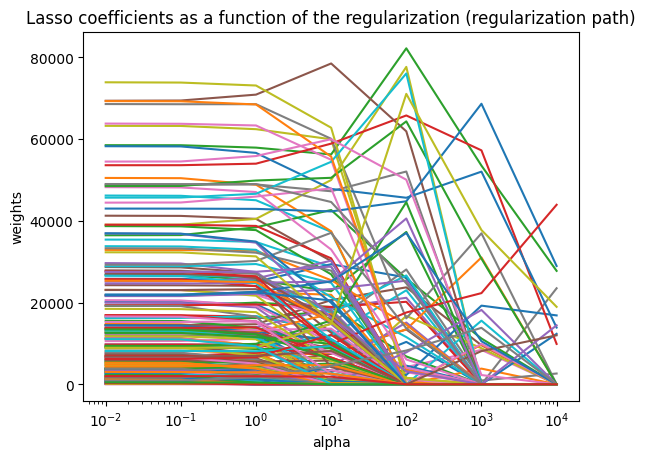

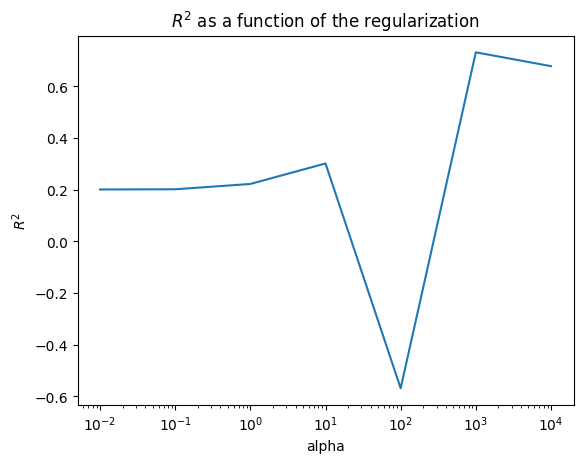

In [88]:
alphas = [0.01,0.1,1,10,1E2,1E3,1E4]
R_2=[]
coefs = []
for alpha in alphas:
    la=Lasso(alpha=alpha)
    
    la.fit(X_train_scaled, y_train)
    coefs.append(abs(la.coef_))
    R_2.append(la.score(X_test_scaled,y_test))


ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of the regularization (regularization path)")
plt.show()


ax = plt.gca()
ax.plot(alphas, R_2)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("$R^2$")
plt.title("$R^2$ as a function of the regularization")
plt.show()

In [89]:
alphas = [0.01,0.1,1.0,10,1E2,1E3,1E4]

lassoCV = LassoCV(alphas=alphas, 
                  cv=4).fit(X_train_scaled, y_train)

/Users/marissawalker/mambaforge/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.149e+08, tolerance: 4.969e+07
  model = cd_fast.enet_coordinate_descent(
/Users/marissawalker/mambaforge/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.131e+07, tolerance: 2.818e+07
  model = cd_fast.enet_coordinate_descent(
/Users/marissawalker/mambaforge/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

In [90]:
lassoCV.alpha_

10000.0

In [91]:
lassoCV.score(X_train_scaled,y_train)

0.8515650996260918

In [92]:
lassoCV.score(X_test_scaled,y_test)

0.6778561551200135

The LassoCV model performs best on the test set!

In [93]:
len(lassoCV.coef_[abs(lassoCV.coef_)>0])

12

Out of the 215 columns we started with, the lasso model just uses 12 of them!

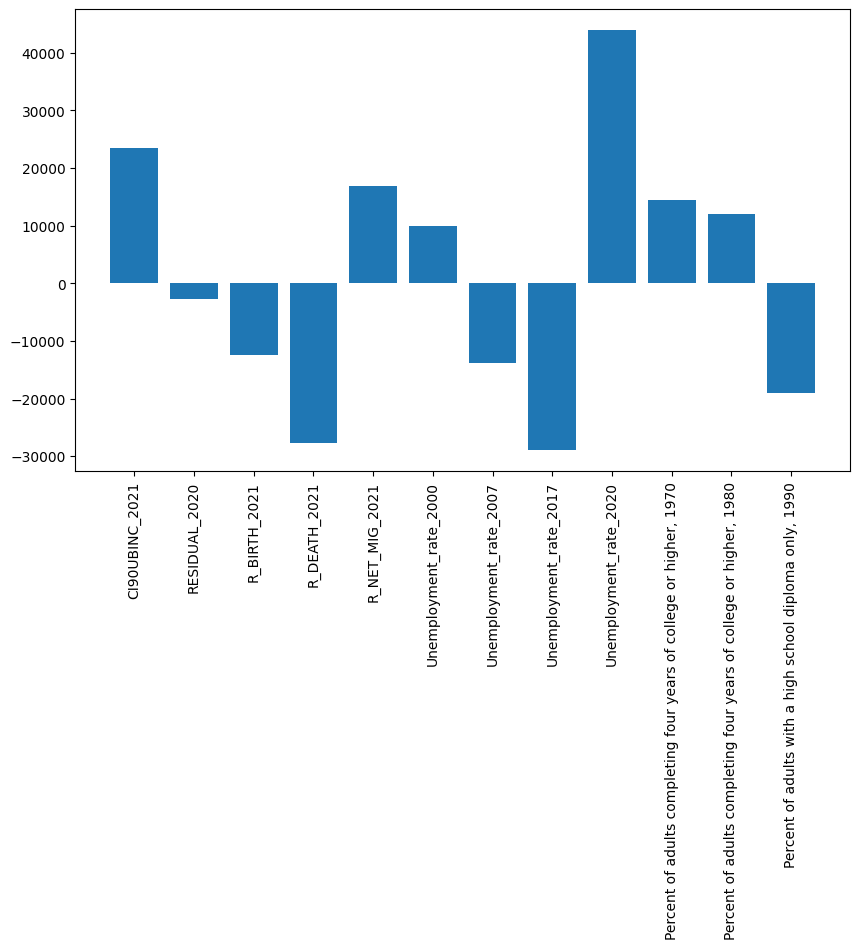

In [94]:
plt.figure(figsize=[10,6])
plt.bar(x=X_train.columns[abs(lassoCV.coef_)>0],height=lassoCV.coef_[abs(lassoCV.coef_)>0])
xticks=plt.xticks(rotation=90)

The highest positive coefficients are unemployment in 2020 (there it is again!) and one of the columns related to household income. 
The strongest negative coefficients are the death rate in 2021 and the unemployment rate in 2017. 

# 4. Insights and key findings

I performed three different types of linear regression: linear regression with all features, regularization using Ridge, and regularization using Lasso.

The model that performed best on test set was Lasso. Using LassoCV to incorporate cross-validation, the model chosen had a high alpha (1E4). It had a score of 0.85 on the training set and 0.67 on the test set. While this model will not be extremely accurate for prediction purposes, it offers some interesting insights on the relationships within this particular data set. I'm not surprised that the score is not higher, given that there are many other factors which influence house price that would not be covered in this data set. 

The results from these models showed positive correlations between average house price  and the rate of unemployment in 2020 as well as with household income. The models also showed a negative correlation with 2021 death rate and unemployment rate in 2017.

# 5. Next Steps

Since this was a very rudimentary exploration, there are many different directions that I could take this next.
1. Conduct a deeper investigation by using the county-level data sets rather than state-by-state. This would require a new housing price estimator, as the Zillow data set is just by state.
2. Research why these factors are correlated by doing some reading from economics experts.
3. Explore other state-level data sets to see what other important factors are missing from this analysis.
4. Try other modeling techniques, such as including polynomial features.